# Table of contents

1. [Introduction](#Introduction) <br>
2. [Imports](#imports)<br>
3. [Data Acquisition](#data_acquisition)<br>
   3.1 [Scraping Challanges](#scraping_challanges)<br>
   3.2 [Util Functions](#util_functions)<br>
   3.3 [Scraping Process](#scraping_process)<br>
   3.4 [Crawling](#crawling)<br>
   3.5 [Data Scraped](#data_scraped)<br>
4. [Data Cleaning](#data_cleaning)<br>
   4.1 [Data NA to Real NA](#data_na_to_real_na)<br>
   4.2 [Cleaning and Converting](#cleaning_and_converting)<br>
   4.3 [Converting to Categorical](#categorical_conversion)<br>
   4.4 [Removing Duplicates](#removing_duplicates)<br>
   4.5 [Filling in missing values](#filling_in_missing_values)<br>
5. [EDA](#eda)<br>
   5.1 [Numeric fields Correlation to Price](#numeric_correlation)<br>
   5.2 [Ram Capacity distribution](#ram_capacity_distribution)<br>
   5.3 [Brands Distribution](#brands_distribution)<br>
   5.4 [Mean price by brand](#mean_price_by_brand_)<br>
   5.5 [Screen size distribution](#screen_size_distribution)<br>
   5.6 [Mean price by screen size](#mean_price_by_screen_size)<br>
   5.7 [Mean price by GPU](#mean_price_by_gpu)<br>
   5.8 [Mean price by GPU](#mean_price_by_series)<br>
6. [Machine Learning](#machine_learning_prep)<br>
   6.1 [Classification](#classification)<br>
   6.2 [Helper Functions](#ml_helper_functions)<br>
   6.3 [Predictions](#predictions)<br>
7. [Conclusion](#conclusion)<br>


<a name='introduction'></a>
# Introduction
<p>
    Today we have so many laptops in the market<br>
    All with different prices, brands, graphic cards, hard drives types and other specs.<br>
    <br>
    we thought to our selves what affects the price the most. is it the brand? is it the graphics card? or is it a simple thing like the type of RAM or hard drive? 
    <br>
    Also, could we predict the price of a laptop based on it's specs? which elements are critical for that prediction?
    <br>
    To answer the above questions we set a goal to our research to see if we can build a model that will predict the price of a laptop based of it's specs and also to figure out along the way which elements of the specs affect the price the most.
</p>

<a id='imports'></a>
<h2 id="imports">Imports</h2>

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score


<a id="data_acquisition"></a>
<h2>Data Acquisition</h2>
<p>Considering our options of data acquisition sources, we decided to look for the biggest electronics comparsion websites and scrape data which we thought will be helpful and save it as a dataframe.

The top options we found were:</p>
<ul>
   <li> <a href="https://zap.com/"target="_blank">Zap</a></li>
    <li><a href="https://amazon.com/"target="_blank">Amazon</a></li>
    <li><a href="https://www.ret.co.il/"target="_blank">Ret</a></li>
    <li><a href="https://www.gadgetsnow.com/"target="_blank">gadgetsnow</a></li>
    <li><a href="https://www.wisebuy.co.il/"target="_blank">wisebuy</a></li>
</ul>

<p>After a punctual search in these websites for relevant data and great community scale, we have decided to move on with Zap due to the popularity of the site and the amount of features provided for each laptop.</p>




<a id='scraping_challanges'></a>
<h3>Scraping challanges</h3>
<p>On our first attempts to scrape the data from Zap we incounterd the following issues:<br>
    <ul>
       <li> When sending too many requests in a short period of time, the website started to slow down and the scraping took a long period of time.</li>
        <li>The default user agent used by requests was python: "requests/2.26.0" and we were blocked by Zap after a few requests.</li>
     </ul>
</p>
<p> The way we dealed with those issues was by using sleep and a custom header.

<a id='util_functions'></a>

<h3>
Some util functions to help scrape the data:
</h3>
<p>
    <ul>
        <li>sleepms- a function made in order to create a delay so the amount of requests sends to the server in parralel will not affect the scraping performance and other users experience in the website</li>
        <li>random_wait- a function which is used in order to create random delay so our scraping methodology will not be detected by the servers.</li>
       <li> get_fake_user_agent- a function which provides us with a non suspectable user agent.</li>

In [2]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 250))

def get_fake_user_agent():
    return {"User-Agent":"PostmanRuntime/7.29.0"}

<a id='scraping_process'></a>
<h3>Scraping Process</h3>
<p>
We went into the website and started exploring in order to find the best route for our scraping proccess.
</p>
<p>
We could clearly see that our best option to get maximum data was in the extra details page which contains huge amount of data.<br>
</p>

<img src="images/extra_details_page.png"/>

</p>
At this point we asked ourselves what is the exact data we wish to scrape?<br>

we decided to go with the following and rename them for the rest of the process:
<ul>
    <li>יצרן - Brand</li>
    <li>תאריך כניסה לזאפ - Zap Enter Date</li>
    <li>התאמה לגיימינג - Gaming Compability</li>
    <li>מערכת הפעלה - Operating System</li>
    <li>תצורת 2 ב- 1 - Two in One</li>
    <li>משקל - Weight</li>
    <li>סדרה - Series</li>
    <li>סוג מעבד - CPU type</li>
    <li>נפח זיכרון RAM - RAM Capacity</li>
    <li>מהירות מעבד - CPU speed</li>
    <li>דגם מעבד - CPU modal</li>
    <li>דור מעבד - CPU generation</li>
    <li>כונן קשיח - Hard drive capacity</li>
    <li>מהירות כונן קשיח - Hard drive Type</li>
    <li>כונן אופטי - Optical Drive</li>
    <li>גודל מסך - Screen Size</li>
    <li>רזולוצית מסך - Screen Resolution</li>
    <li>סוג מסך - Screen Type</li>
    <li>קצב ריענון תצוגה - FPS</li>
    <li>מסך מגע - Touch Screen</li>
    <li>כרטיס מסך - GPU</li>
    <li>מצלמת רשת - Web camera</li>
    <li>אמצעי אבטחה - Secutiry</li>
    <li>חיבורים - Connectors</li>
    <li>רשת אלחוטית - Wifi modal</li>
    <li>מודם סלולרי - Cellular modem</li>
    <li>מחיר מינימלי - Min price</li>
    <li>מחיר מקסימלי - Max price</li>
</ul>
Also, we decided to save the page number in which Zap decided to place the laptop, we figured it has a meaning we could use:
<ul>
    <li>Page Number</li>
</ul>


In [3]:
def crawl_data(link): 
    page = requests.get(link, headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.findAll ('div', {'class' : 'detailsRow'}, limit=None)
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    spans = soup.find('div','PricesTxt').findAll('span') 
    if len(spans) == 2:
        values = [ spans[1].text, spans[0].text ]
    elif len(spans) == 1: 
        values = [ spans[0].text, spans[0].text ]
    else:
        values = [ None,None ]
    
    for i in range(0, len(links)):
        titles.append(links[i].find('div','detailsRowTitle').text.replace('?','').strip())
        values.append(links[i].find('div','detailsRowTxt').text.strip())


    return dict(zip(titles,values))

In [4]:
def translate_names(df):
    translated_df = pd.DataFrame()
    translation = {
   "יצרן":"Brand",
   "תאריך כניסה לזאפ":"Zap Enter Date",
   "התאמה לגיימינג":"Gaming Compability",
   "מערכת הפעלה":"Operating System",
   "תצורת ‎ 2 in 1":"Two in One",
   "משקל":"Weight",
   "סדרה":"Series",
   "סוג מעבד":"CPU type",
  "נפח זיכרון RAM":"RAM Capacity",
   "מהירות מעבד":"CPU speed",
   "דגם מעבד":"CPU modal",
   "דור מעבד":"CPU generation",
   "כונן קשיח":"Hard drive capacity",
   "מהירות כונן קשיח":"Hard drive Type",
  "כונן אופטי":"Optical Drive",
   "גודל מסך":"Screen Size",
   "רזולוציית מסך":"Screen Resolution",
   "סוג מסך":"Screen Type",
   "קצב רענון תצוגה":"FPS",
   "מסך מגע":"Touch Screen",
   "כרטיס מסך":"GPU",
   "מצלמת רשת":"Web camera",
   "אמצעי אבטחה":"Secutiry",
   "חיבורים":"Connectors",
   "רשת אלחוטית":"Wifi modal",
   "מודם סלולארי":"Cellular modem",
   "מחיר מינימלי":"Min price",
   "מחיר מקסימלי":"Max price",
   "Page Number": "Page number",
   "סוג הזכרון": "Memory type"}

    for key, value in translation.items():
        translated_df[value] = df[key]

    return translated_df

<a id='crawling'></a>
<h3>Crawling</h3>
<p>
At this point, we considered different tools for crawling data from zap:
<ul>
<li>BeautifulSoup - a library in python that allows to crawl data via xpath in a simple way</li>
<li>Scrapy - a free open source web-crawling framework written in python, the library allows crawling for data via xpath </li>
<li>Selenum - a tool for automation testing, the selenuim framework is divided into two parts: selenuim sdk and chrome driver. This tool also allows crawling for data via xpath </li>
</ul>

Eventually, we chose BeautifulSoup.
</p>

```python
def zap_data_crawl_all(BASE_URL,filename,page):
    index = page
    df = pd.DataFrame()
    url = f'{BASE_URL}models.aspx?sog=c:"pclaptop&pageinfo={index}'
    page = requests.get(url,headers = get_fake_user_agent())
    soup = BeautifulSoup(page.text, 'html.parser')
    while soup.select_one('.selectedNumBtn') and soup.select_one('.selectedNumBtn').text == str(index):
        print(f'page number {index}')
        links = soup.findAll ('div', {'class' : 'MoreInfo'}, limit=None)   
        for i in range(0, len(links)):
            link = BASE_URL + links[i].find('a')["href"]
            cd = crawl_data(link)
            cd['מספר עמוד'] = index
            df = pd.concat([df,pd.DataFrame([cd])])
            
        index += 1
        random_wait()
        url = f'{BASE_URL}models.aspx?sog=c:"pclaptop&pageinfo={index}'
        page = requests.get(url,headers = get_fake_user_agent())
        soup = BeautifulSoup(page.text, 'html.parser')
    translated_df = translate_names(df)
    translated_df.to_csv(filename, index=False ,encoding = 'utf:"8:"sig')



```

In [6]:
BASE_URL ="https://www.zap.co.il/"
filename = 'laptops_data.csv'
page = 1

```python

zap_data_crawl_all(BASE_URL, filename, page)
```

<a id='data_scraped'></a>
<h3>Let's check how much data did we scrape before we start cleaning it (if needed)</h3>

In [ ]:
laptops_df = pd.read_csv(filename)
print(f"df shape:{laptops_df.shape}")
print(f"data amount before cleaning: {'{:,}'.format(laptops_df.shape[0] * laptops_df.shape[1])} (rows * cols)")
laptops_df.head(10)

df shape:(3112, 30)
data amount before cleaning: 93,360 (rows * cols)


,Brand,Zap Enter Date,Gaming Compability,Operating System,Two in One,Weight,Series,CPU type,RAM Capacity,CPU speed,...,GPU,Web camera,Secutiry,Connectors,Wifi modal,Cellular modem,Min price,Max price,Page number,Memory type
0,Apple,2021,גיימינג,MacOS,ללא,"1.29 ק""ג",MacBook Air,M1,8 GB,לא זמין,...,לא זמין,1 מגה פיקסל,קורא טביעות אצבע,"DisplayPort , Thunderbolt , USB-C , Bluetooth ...","WiFi 6 , 802.11ax",לא כולל,"3,698","5,108",1,לא זמין
1,Lenovo,2021,גיימינג,ללא,ללא,"1.85 ק""ג",V14 ADA,AMD,4 GB,לא זמין,...,Integrated AMD Radeon Graphics,לא זמין,לא כולל,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,970,"1,970",1,DDR4
2,Lenovo,מ 2022,גיימינג,ללא,ללא,"1.7 ק""ג",ThinkBook 15 G2,Intel Core i7,16 GB,2800Mhz,...,Integrated Intel Iris Xe Graphics,1 מגה פיקסל,לא כולל,"RJ-45 , DisplayPort , Thunderbolt , Card Reade...","WiFi 6 , 802.11ax",לא כולל,"2,849","3,820",1,DDR4
3,Asus,2021,גיימינג,ללא,ללא,"1.8 ק""ג",לא רלוונטי,Intel Core i3,16 GB,3000Mhz,...,Intel Iris Xe Graphics,כולל,לא כולל,"אוזניות/מיקרופון , USB-C , HDMI , Bluetooth , USB",802.11ac,לא כולל,"1,599","2,263",1,DDR4
4,Apple,2021,גיימינג,MacOS,ללא,"1.6 ק""ג",MacBook Pro,M1,16 GB,לא זמין,...,לא זמין,כולל,קורא טביעות אצבע,"DisplayPort , Thunderbolt , אוזניות/מיקרופון ,...","WiFi 6 , 802.11ax",לא כולל,"7,421","8,166",1,לא זמין
5,Lenovo,2020,גיימינג,ללא,ללא,"1.6 ק""ג",לא רלוונטי,AMD,4 GB,1200Mhz,...,Integrated AMD Radeon Graphics,כולל,לא כולל,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,815,"1,710",1,DDR4
6,Lenovo,מ 2022,גיימינג,Windows 11 Home,מסך מסתובב,"1.5 ק""ג",IdeaPad Flex 5,Intel Core i5,8 GB,2400Mhz,...,Integrated Intel Iris Xe Graphics,1 מגה פיקסל,קורא טביעות אצבע,"Card Reader , אוזניות/מיקרופון , USB-C , HDMI ...",802.11ax,לא כולל,"2,699","3,519",1,DDR4
7,Asus,2021,גיימינג,Windows 10 PRO,ללא,"1.2 ק""ג",לא רלוונטי,Intel Celeron,4 GB,1100Mhz,...,לא זמין,כולל,לא זמין,"Card Reader , אוזניות/מיקרופון , HDMI , Blueto...",802.11ac,לא כולל,865,"1,290",1,DDR3
8,Apple,2021,גיימינג,MacOS,ללא,"1.29 ק""ג",MacBook Air,M1,16 GB,לא זמין,...,לא זמין,1 מגה פיקסל,לא כולל,"DisplayPort , Thunderbolt , אוזניות/מיקרופון ,...",כולל,לא כולל,"4,506","4,998",1,לא זמין
9,Apple,2021,גיימינג,MacOS,ללא,"1.4 ק""ג",MacBook Pro,M1,8 GB,לא זמין,...,לא זמין,1 מגה פיקסל,קורא טביעות אצבע,"Thunderbolt , אוזניות/מיקרופון , USB-C , Bluet...","WiFi 6 , 802.11ax",לא כולל,"4,849","5,548",1,לא זמין


<a id='data_cleaning'></a>
<h2>Data Cleaning</h2>


<a id='data_na_to_real_na'></a>

<h3>Turning Zap's NA's to real NA's</h3>

In [ ]:
laptops_real_na = laptops_df.copy()
for col in laptops_real_na:
    laptops_real_na.loc[(laptops_real_na[col] == 'לא זמין') | (laptops_real_na[col] == 'יעודכן בקרוב') | (laptops_real_na[col] == "לא רלוונטי"), col] = None 

<a id='cleaning_and_converting'></a>

<h3>Cleaning and converting to numeric</h3>

In [ ]:
def cleaning_and_converting(df):
    df['Zap Enter Date'] = pd.to_numeric(df['Zap Enter Date'].str.replace('מ','').str.replace('עד','').str.strip())
    df['RAM Capacity'] = pd.to_numeric(df['RAM Capacity'].str.replace('GB','').str.strip())
    df['CPU speed'] = pd.to_numeric(df['CPU speed'].str.replace('Mhz','').str.replace('MHz','').str.strip())
    df['CPU generation'] = pd.to_numeric(df['CPU generation'].str.replace('דור','').str.strip())
    df['Screen Size'] = pd.to_numeric(df['Screen Size'].str.replace('אינטש','').str.strip())
    df["FPS"] = pd.to_numeric(df["FPS"].str.lower().str.replace('hz','').str.strip())
    
    df["Memory type"] = pd.to_numeric(df["Memory type"].str.replace('DDR','').str.strip())
    
    df['Hard drive capacity'] = df['Hard drive capacity'].str.replace('GB','').str.strip()
    for i in range(len(df['Hard drive capacity'])):
        if not df.loc[i, 'Hard drive capacity']:
            continue
        arr = df.loc[i, 'Hard drive capacity'].replace(",","+").split("+")
        if len(arr) > 1:
            sum = 0
            for num in arr:
                sum += int(num)
            df.loc[i, 'Hard drive capacity'] = sum
        else:
            df.loc[i, 'Hard drive capacity'] = int(arr[0])

    
    df['Screen Resolution'] = df['Screen Resolution'].str.replace('X','x')
    df['Weight'] = df['Weight'].str.replace('ק"ג','').str.strip()
    df['Weight']= pd.to_numeric(df['Weight'])
    
    df['Max price'] = pd.to_numeric(df['Max price'].str.replace(',',''))
    df['Min price'] = pd.to_numeric(df['Min price'].str.replace(',','' ))

cleaning_and_converting(laptops_real_na)


<a id='categorical_conversion'></a>
<h3>Converting to Categorical</h3>

In [ ]:
laptops_real_na["Touch Screen"] =  np.where(laptops_real_na['Touch Screen']  == "כולל" , 1 , 0)

<a id='removing_duplicates'></a>
<h3>Removing Duplicates</h3>

In [ ]:
laptops_no_dup = laptops_real_na[~laptops_real_na.duplicated()]

<p>Lets see how many rows did we lose and the NA count:</p>

In [ ]:
laptops_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 0 to 3111
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                3112 non-null   object 
 1   Zap Enter Date       3112 non-null   int64  
 2   Gaming Compability   368 non-null    object 
 3   Operating System     2838 non-null   object 
 4   Two in One           2778 non-null   object 
 5   Weight               2811 non-null   float64
 6   Series               2558 non-null   object 
 7   CPU type             2858 non-null   object 
 8   RAM Capacity         2866 non-null   float64
 9   CPU speed            2696 non-null   float64
 10  CPU model            2761 non-null   object 
 11  CPU generation       2740 non-null   float64
 12  Hard drive capacity  2869 non-null   object 
 13  Hard drive Type      2812 non-null   object 
 14  Optical Drive        2827 non-null   object 
 15  Screen Size          2864 non-null   f

<p>It looks like we didn't have any duplicates. so lets continue reviewing the NA's:</p>

In [ ]:
laptops_no_dup.describe()

,Zap Enter Date,Weight,RAM Capacity,CPU speed,CPU generation,Screen Size,FPS,Touch Screen,Min price,Max price,Page number,Memory type
count,3112.000000,2811.000000,2866.000000,2696.000000,2740.000000,2864.000000,2733.000000,3112.000000,3112.000000,3112.000000,3112.000000,2636.000000
mean,2021.057841,1.703291,14.338451,2584.543398,10.054380,14.809951,69.849616,0.180270,5467.699871,5866.624036,65.357969,3.995448
std,0.839707,0.438811,8.044807,680.889725,2.029978,1.107846,34.015914,0.384474,3198.940776,3330.744863,37.455493,0.180601
min,2017.000000,0.340000,2.000000,933.000000,2.000000,10.300000,60.000000,0.000000,799.000000,889.000000,1.000000,3.000000
25%,2021.000000,1.400000,8.000000,2400.000000,10.000000,14.000000,60.000000,0.000000,3190.000000,3490.000000,33.000000,4.000000
50%,2021.000000,1.650000,16.000000,2550.000000,11.000000,15.600000,60.000000,0.000000,4553.500000,4990.000000,65.000000,4.000000
75%,2022.000000,1.900000,16.000000,2800.000000,11.000000,15.600000,60.000000,0.000000,6896.000000,7389.250000,98.000000,4.000000
max,2022.000000,4.630000,64.000000,5000.000000,12.000000,17.300000,300.000000,1.000000,25361.000000,25361.000000,130.000000,5.000000


<p>
it looks like the following coulmns are lacking in data:
<ul>
<strong>
<li>CPU model</li>
<li>Gaming compability</li>
<li>CPU generation</li>
<li>GPU</li>
<li>CPU speed</li>
<li>Memory type</li>
</strong>
</ul>

</p>

<a id='none_values'></a>
<p>
    Let's check how many total books are there without any NA values:
</p>    

In [ ]:
laptops_no_dup.dropna(how='any').info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 6 to 367
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                265 non-null    object 
 1   Zap Enter Date       265 non-null    int64  
 2   Gaming Compability   265 non-null    object 
 3   Operating System     265 non-null    object 
 4   Two in One           265 non-null    object 
 5   Weight               265 non-null    float64
 6   Series               265 non-null    object 
 7   CPU type             265 non-null    object 
 8   RAM Capacity         265 non-null    float64
 9   CPU speed            265 non-null    float64
 10  CPU model            265 non-null    object 
 11  CPU generation       265 non-null    float64
 12  Hard drive capacity  265 non-null    object 
 13  Hard drive Type      265 non-null    object 
 14  Optical Drive        265 non-null    object 
 15  Screen Size          265 non-null    flo

<p>Almost a third missing! thats not good...</p>
<p>First, by looking at the data it seems like:
<br>
<ul>
    <li><strong>Gaming compability</strong></li>
    <li><strong>CPU model</strong></li>
    <li><strong>Optical Drive</strong></li>
    <li><strong>Cellular modem</strong></li>
</ul>
are unnecessary. so, we would like to remove them:</p>

In [ ]:
laptops_no_dup = laptops_no_dup.drop(["CPU model","Gaming Compability",'Optical Drive','Cellular modem' ] , axis = 1) 
laptops_no_dup.dropna(how='any').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1949 entries, 6 to 3111
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                1949 non-null   object 
 1   Zap Enter Date       1949 non-null   int64  
 2   Operating System     1949 non-null   object 
 3   Two in One           1949 non-null   object 
 4   Weight               1949 non-null   float64
 5   Series               1949 non-null   object 
 6   CPU type             1949 non-null   object 
 7   RAM Capacity         1949 non-null   float64
 8   CPU speed            1949 non-null   float64
 9   CPU generation       1949 non-null   float64
 10  Hard drive capacity  1949 non-null   object 
 11  Hard drive Type      1949 non-null   object 
 12  Screen Size          1949 non-null   float64
 13  Screen Resolution    1949 non-null   object 
 14  Screen Type          1949 non-null   object 
 15  FPS                  1949 non-null   f

<p>Not a big improvement... lets try filling-in the rest:</p>


<a id='filling_in_missing_values'></a>
<h3>Filling in missing values<h3>

<h4>First, lets try filling-in <strong>CPU generation</strong>:</h4>
<h5>Mean or Median?</h5>
<p>
    In order to decide in which metric to replace <strong>CPU generation</strong> (mean/median) we want to replace NA values we wanted to base our decision over the distribution of the metric.
</p>

2.0
12.0


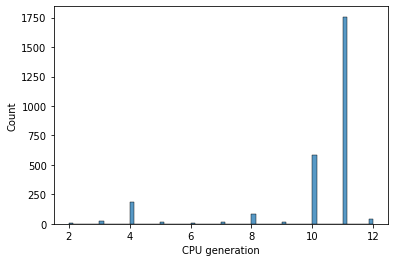

In [ ]:
print(laptops_no_dup['CPU generation'].min())
print(laptops_no_dup['CPU generation'].max())

sns.histplot(laptops_no_dup['CPU generation'])
plt.show()

<p>it seems like 11 is the right choice to fill-in the NA's so we'll go with that</p>

In [ ]:
most_freq_CPU_generation = laptops_no_dup['CPU generation'].mode()[0]
laptops_no_dup['CPU generation'] = laptops_no_dup['CPU generation'].fillna(most_freq_CPU_generation)


<h3>Lets do the same for <strong>CPU speed</strong>:</h3>


933.0
5000.0


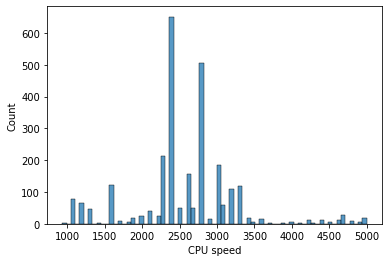

In [ ]:
print(laptops_no_dup['CPU speed'].min())
print(laptops_no_dup['CPU speed'].max())

sns.histplot(laptops_no_dup['CPU speed'])
plt.show()

<p>
As can be seen, the distribution can show us that there are not so many outliers.
So we are going to use mean.
</p>

In [ ]:
cpu_speed_mean = laptops_no_dup['CPU speed'].mean()

laptops_no_dup['CPU speed'] = np.where(
    laptops_no_dup['CPU speed'].isnull(),
    cpu_speed_mean,
    laptops_no_dup['CPU speed']
)



<h3>Now, lets try filling-in <strong>GPU</strong> and <strong>Memory type</strong>:</h3>
<p>
  GPU and Memory type are string values, so we'll do the same for them:
</p>

In [ ]:
most_freq_GPU = laptops_no_dup['GPU'].mode()[0]
laptops_no_dup['GPU'] = laptops_no_dup['GPU'].fillna(most_freq_GPU)

most_freq_memory_type = laptops_no_dup['Memory type'].mode()[0]
laptops_no_dup['Memory type'] = laptops_no_dup['Memory type'].fillna(most_freq_memory_type)


<p>lets see how that went for us:</p>

In [ ]:
laptops_no_dup.dropna(how='any').info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2180 entries, 0 to 3111
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2180 non-null   object 
 1   Zap Enter Date       2180 non-null   int64  
 2   Operating System     2180 non-null   object 
 3   Two in One           2180 non-null   object 
 4   Weight               2180 non-null   float64
 5   Series               2180 non-null   object 
 6   CPU type             2180 non-null   object 
 7   RAM Capacity         2180 non-null   float64
 8   CPU speed            2180 non-null   float64
 9   CPU generation       2180 non-null   float64
 10  Hard drive capacity  2180 non-null   object 
 11  Hard drive Type      2180 non-null   object 
 12  Screen Size          2180 non-null   float64
 13  Screen Resolution    2180 non-null   object 
 14  Screen Type          2180 non-null   object 
 15  FPS                  2180 non-null   f

In [ ]:
laptop_eda = laptops_no_dup.copy().dropna(how='any') 

<p>we saved 500 rows! what a success!</p>


<a id='min_max_to_price'></a>
<h3>Min price, Max price to just Price!</h3>
<p>
    currently, Zap provided us with <strong>Min Price</strong> and <strong>Max Price</strong><br>
    but for our predictions we will need only <strong>Price</strong>.
</p>

In [ ]:
laptop_eda['Price'] = (laptop_eda['Max price'] + laptop_eda['Min price'])/2
laptop_eda['Price'] = (laptop_eda['Price'] - laptop_eda['Price'].min()) / (laptop_eda['Price'].max() - laptop_eda['Price'].min())
laptop_eda = laptop_eda.drop(["Max price" , "Min price" ] , axis = 1) 

<a id='eda'></a>
<h1>EDA</h1>

<p>
    <ul>
        <li>create_heatmap - a function made in order to create and display a heatmap.</li>

In [ ]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('Price')
    numeric_df.insert(0, 'Price', first_col)
    sns.heatmap(numeric_df.corr())

<a id='numeric_correlation'></a>
<h3>Numeric fields Correlation to Price</h3>
<p>We would like now to create a heatmap in order to check the correlation of the numeric values on the price:</p>

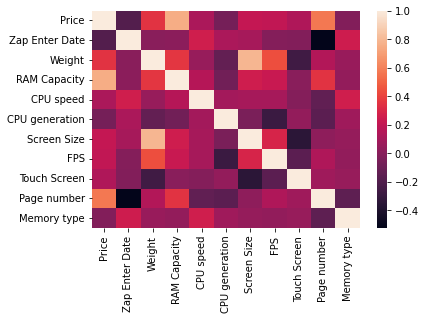

In [ ]:
laptops_for_heatmap = laptop_eda.select_dtypes(include='number')
create_heatmap(laptops_for_heatmap)

<p>As we can see, the numeric values alone won't help us in our research. but, it seems like we should look into <strong>Ram capacity</strong>.<br>
<strong>Page Number</strong> also has a high correlation to price. We can learn from that, that relevence affects the price as well.</p>

<a id='ram_capacity_distribution'></a>
<h3>Ram Capacity distribution</h3>

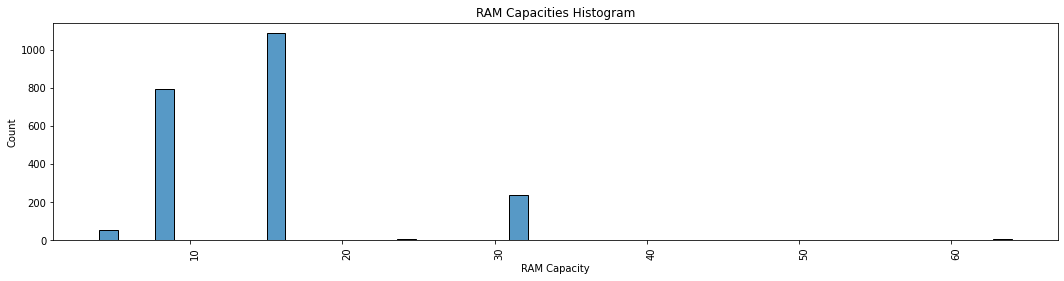

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(laptop_eda['RAM Capacity'], ax=ax)
fg.set_title("RAM Capacities Histogram")
fg.set_xlabel("RAM Capacity")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>it seems that most laptops use 8 or 16 GB of RAM.</p>

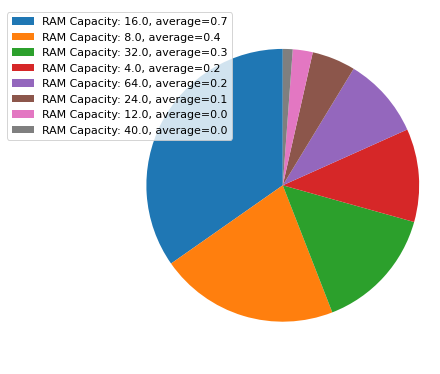

In [ ]:
ram_capacity_counts = laptop_eda['RAM Capacity'].value_counts()
laptops_price_mean_by_ram_capacity = laptop_eda.groupby('RAM Capacity', as_index=False)['Price'].mean()
laptops_price_mean_by_ram_capacity.sort_values(by="Price", inplace=True, ascending=False)

labels = ["RAM Capacity: %s" % i for i in ram_capacity_counts.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_ram_capacity['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_ram_capacity.index, laptops_price_mean_by_ram_capacity['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

<p>We can learn from this graph that high priced laptops use 8 and 16 GB RAM. due to their distrabution we assume it's because of their populatiry</p>

<a id='brands_distribution'></a>
<h3>Brands distribution</h3>

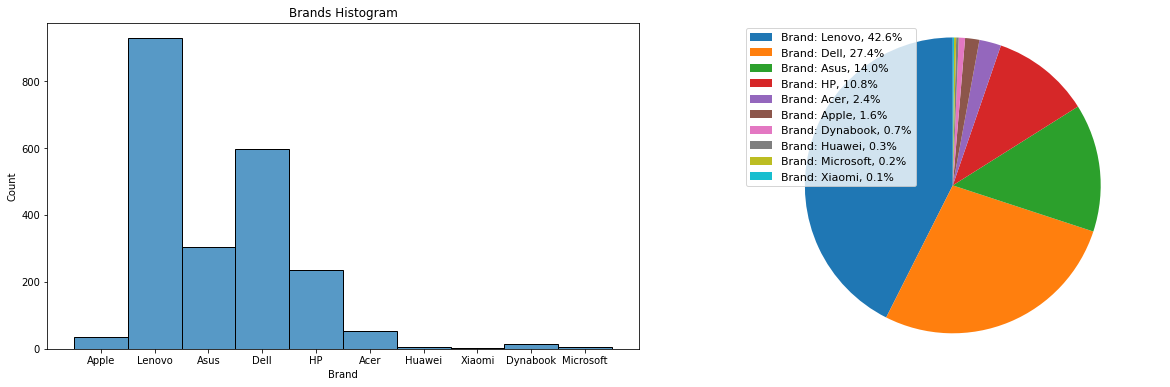

In [ ]:

fig = plt.figure(figsize=(20, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3.5, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


#histogram:
fg = sns.histplot(laptop_eda['Brand'], ax=ax1)
fg.set_title("Brands Histogram")
fg.set_xlabel("Brand")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')

laptopts_by_brand_count = laptop_eda['Brand'].value_counts()

total_laptops = laptop_eda.shape[0]

labels = ["Brand: %s" % i for i in laptopts_by_brand_count.index]

#pie chart:
_, _ = ax2.pie(laptopts_by_brand_count.values, startangle=90)

ax2.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (v / total_laptops * 100)) for l, s, v in zip(labels, laptopts_by_brand_count.index, laptopts_by_brand_count.values)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    # bbox_transform=fig1.transFigure
)
plt.show()

<p>as can be seen, Lenovo, Asus, Dell and HP are the largest "players" in the market. and Apple and Acer also take a small portion of the market</p><br>
<p>this also checks out with a simple google search:</p>

<img width="50%" height="50%" style="margin-right:5px" src="images/laptop_market_share_1.png"/><img src="images/laptop_market_share_2.png"/>

<a id='mean_price_by_brand_'></a>

<h3>Mean price by brand</h3>

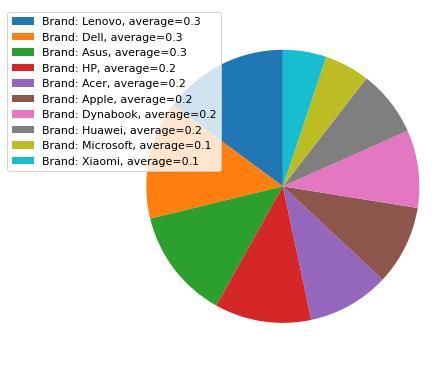

In [ ]:
laptops_price_mean_by_brand = laptop_eda.groupby('Brand', as_index=False)['Price'].mean()
laptops_price_mean_by_brand.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Brand: %s" % i for i in laptopts_by_brand_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_brand['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_brand.index, laptops_price_mean_by_brand['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<a id='screen_size_distribution'></a>
<h3>Screen size distribution</h3>

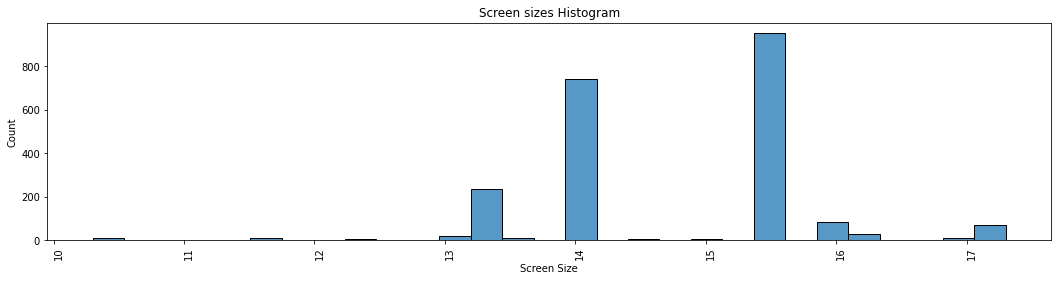

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
fg = sns.histplot(laptop_eda['Screen Size'], ax=ax)
fg.set_title("Screen sizes Histogram")
fg.set_xlabel("Screen Size")
plt.xticks(rotation=90, ha='right', rotation_mode='anchor')
plt.show()

<p>It's easy to see that 15.6 inches and 14 inches make most of the market. next, we'll check if screen size affects the price.</p>

<a id='mean_price_by_screen_size'></a>

<h3>Mean price by screen size</h3>

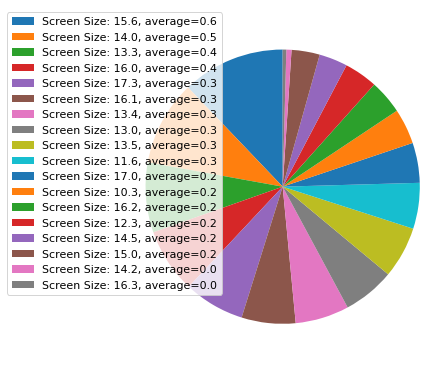

In [ ]:
laptopts_by_screen_size_count = laptop_eda['Screen Size'].value_counts()

laptops_price_mean_by_screen_size = laptop_eda.groupby('Screen Size', as_index=False)['Price'].mean()
laptops_price_mean_by_screen_size.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Screen Size: %s" % i for i in laptopts_by_screen_size_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_screen_size['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_screen_size.index, laptops_price_mean_by_screen_size['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>It seems that the screen size does affect the price, but considering that 15.5 and 14 inches make most of the market it's not suprising.</p>

<a id='mean_price_by_gpu'></a>

<h3>Mean price by GPU</h3>

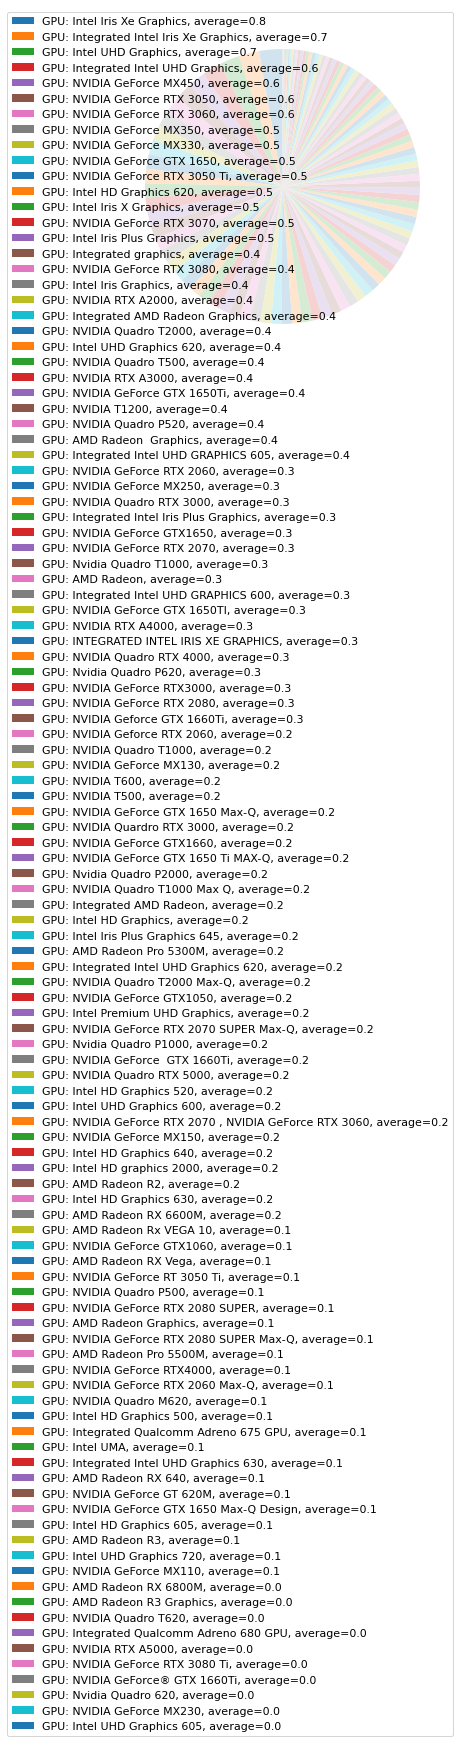

In [ ]:
laptopts_by_gpu_count = laptop_eda['GPU'].value_counts()

laptops_price_mean_by_gpu = laptop_eda.groupby('GPU', as_index=False)['Price'].mean()
laptops_price_mean_by_gpu.sort_values(by="Price", inplace=True, ascending=False)

labels = ["GPU: %s" % i for i in laptopts_by_gpu_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_gpu['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_gpu.index, laptops_price_mean_by_gpu['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>it seems like GPU's affects the price!</p>

<a id='mean_price_by_series'></a>

<h3>Mean price by series</h3>

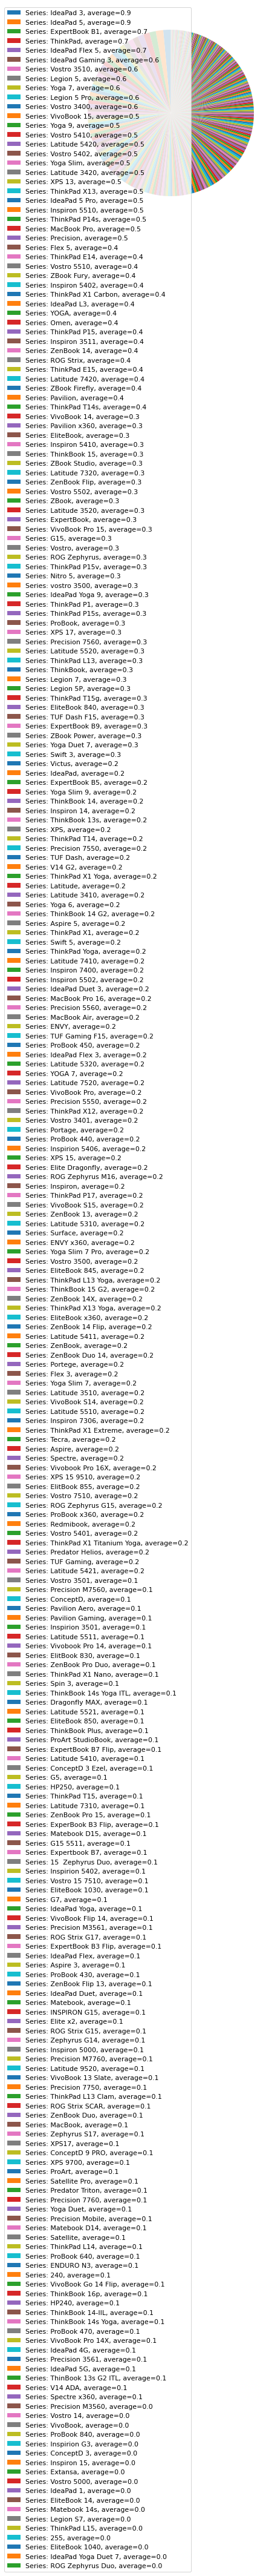

In [ ]:
laptopts_by_Series_count = laptop_eda['Series'].value_counts()

laptops_price_mean_by_Series = laptop_eda.groupby('Series', as_index=False)['Price'].mean()
laptops_price_mean_by_Series.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Series: %s" % i for i in laptopts_by_Series_count.index]

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(laptops_price_mean_by_Series['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, laptops_price_mean_by_Series.index, laptops_price_mean_by_Series['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()


<p>it seems like series affects the price!</p>

<a id='machine_learning'></a>
<h1>Machine Learning</h1>

In [ ]:
laptops_ml = laptop_eda.copy()

<a id='classification'></a>

<h3>Classification of the problem</h3>
<p>We want to predict the price of a laptop based on his specs.<br>
Because what we are predicting is a number, we are facing a suprivesd learning problem called:<br>
<strong>Regression on a continuous variable.</strong><br>
We can solve that problem by using: <strong>Linear Regression.</strong> 
</p>

<a id='ml_helper_functions'></a>

<h3>Helper Functions:</h3>
<p>
<ul>
    <li>train_model - trains the model </li>
    <li>evaluate_performance - evaluates the performance of the model</li>
    <li>split_to_X_and_y - splits the prediction column from the dataframe</li>
    <li>predict - prints a linear regression predicton evaluation of a dataframe using the above functions.</li>
</ul>
</p>


In [ ]:
def train_model(X, y):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X, y)

In [ ]:
def evaluate_performance(y,y_predicted):
    return metrics.r2_score(y, y_predicted)

In [ ]:
def split_to_X_and_y(df, target_column):
    return df.drop([target_column],axis = 1), df[target_column]

In [ ]:
def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X, y = split_to_X_and_y(numeric_df,'Price')
    trained_model = train_model(X, y)
    pred_vals = trained_model.predict(X)
    y_pred= pd.Series(pred_vals,index=X.index)
    eval_res = evaluate_performance(y, y_pred)
    print('amount of data:', X.shape[0] * X.shape[1])
    print('prediction:', eval_res)

<a id='predictions'></a>
<h3>Predictions</h3>

<p>First, let's use <strong>Linear Regression</strong> on the dataframe as it to see what's our current prediction:</p>

In [ ]:
predict(laptops_ml)

amount of data: 21800
prediction: 0.7022138334445454


<p>Lets try to improve that by adding some features:</p>

In [ ]:
def features(df):
    df['Screen Resolution'] = df['Screen Resolution'].apply(lambda s: int(s.split('x')[0]) *int(s.split('x')[1]))
    df['Screen Resolution'] = (df['Screen Resolution'] - df['Screen Resolution'].min()) / (df['Screen Resolution'].max() - df['Screen Resolution'].min())    
    return df  

<p>let's predict again:</p>

In [ ]:
laptops_ml_with_features = features(laptops_ml.copy())
predict(laptops_ml_with_features)

amount of data: 23980
prediction: 0.7236647897788964


<p>Adding features helped a bit, but not enough.</p>

<p>
<ul>
    <li>categorial_to_numerical - turns a categorical column to numerical using <strong>pd.get_dummies</strong> </li>
</ul>
</p>

In [ ]:
def categorial_to_numerical(df, columns):
    return pd.get_dummies(df, columns=columns)

<p>In the EDA section we saw that <strong>Series</strong> affects the price. lets try converting it to numerical and see if that helps:<br>
(by doing so, we are increasing the amount of data the model is working on, so we won't over use this method)</p>

In [ ]:
laptops_ml_with_categorical = categorial_to_numerical(laptops_ml_with_features.copy(),['Series'])
predict(laptops_ml_with_categorical)

amount of data: 619120
prediction: 0.9230701983587466


<p>lets try anoter feature to see if it has the same affect:</p>

In [ ]:
laptops_ml_with_categorical = categorial_to_numerical(laptops_ml_with_features.copy(),['GPU'])
predict(laptops_ml_with_categorical)

amount of data: 265960
prediction: 0.8209922102266958


<p>wow! also a great influnce. not as much as <strong>Series</strong> but also quite big.<br>
Also, a lot less demanding on the amount of data.</p>
<p>Lets combine them:</p>

In [ ]:
laptops_ml_with_categorical = categorial_to_numerical(laptops_ml_with_features.copy(),['GPU','Series'])
predict(laptops_ml_with_categorical)

amount of data: 861100
prediction: 0.9471988869411518


<p>We'll stop here. this is a great result and the data is getting quite big.<br>
Also, we wouldn't want to overfit the model.</p>

<a id='conclusion'></a>
<h2>Conclusion</h2>

In [ ]:
laptops_conclusion = laptops_ml[['Price','Screen Resolution','RAM Capacity','GPU','Series']].copy()
laptops_conclusion = features(laptops_conclusion)
laptops_conclusion = categorial_to_numerical(laptops_conclusion,['GPU','Series'])
predict(laptops_conclusion)

amount of data: 841480
prediction: 0.9380773462977187


<p>
    Predicting the price of a laptop with an accurecy of 0.94 requires knowledge of:<br>
    <ul>
        <li>RAM capacity</li>
        <li>series</li>
        <li>GPU</li>
        <li>Screen resolution</li>
    </ul>
    
    Suprisingly, the Brand doesn't affect the price. 
</p>  